# A/B test and Heterogenous effects of iPhone vs Android 
### A/B Conditions: 
    
control: users who have been shown a dummy ad

exposed: users who have been shown a creative, an online interactive ad, with the SmartAd brand.
  
### Outcome: 

yes: 1 if the user chooses the “Yes” radio button for the BIO questionnaire.

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, skew
from scipy import stats
import statsmodels.api as sm
import seaborn as sns


In [13]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [102]:
## Load ab test data
df = pd.read_csv('AdSmartABdata.csv', sep = ',', parse_dates=['date'])

In [103]:
## Check NULL
df.isna().any()

auction_id     False
experiment     False
date           False
hour           False
device_make    False
platform_os    False
browser        False
yes            False
no             False
dtype: bool

In [104]:
df

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
...,...,...,...,...,...,...,...,...,...
8072,ffea24ec-cec1-43fb-b1d1-8f93828c2be2,exposed,2020-07-05,7,Generic Smartphone,6,Chrome Mobile,0,0
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,2020-07-04,9,Generic Smartphone,6,Chrome Mobile,0,0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,2020-07-05,15,Samsung SM-A515F,6,Samsung Internet,0,0


In [105]:
## Label encode binary features for columns with 2 or less unique values

le = LabelEncoder()

le_count = 0
for col in df.columns[1:]:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            le.fit(df[col])
            df[col] = le.transform(df[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

1 columns were label encoded.


In [106]:
## Define two proprotions z test
def two_proprotions_test(success_a, size_a, success_b, size_b):
    """
    A/B test for two proportions;
    given a success a trial size of group A and B compute
    its zscore and pvalue
    
    Parameters
    ----------
    success_a, success_b : int
        Number of successes in each group
        
    size_a, size_b : int
        Size, or number of observations in each group
    
    Returns
    -------
    zscore : float
        test statistic for the two proportion z-test

    pvalue : float
        p-value for the two proportion z-test
    """
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    effect = prop_a - prop_b
    prop_pooled = (success_a + success_b) / (size_a + size_b)
    var = prop_pooled * (1 - prop_pooled) * (1 / size_a + 1 / size_b)
    zscore = np.abs(prop_b - prop_a) / np.sqrt(var)
    one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)
    pvalue = one_side * 2
    return zscore, pvalue, effect

In [107]:
df_t = df.loc[df['experiment'] == 1, :]
df_c = df.loc[df['experiment'] == 0, :]

In [108]:
success_a = sum(df_t['yes'])
size_a = len(df_t['yes'])
success_b = sum(df_c['yes'])
size_b = len(df_c['yes'])

zscore, pvalue, effect = two_proprotions_test(success_a, size_a, success_b, size_b)

In [109]:
effect

0.012035741524044075

In [110]:
pvalue

0.03500582596832458

In [111]:
## OLS results same as z test
y = df['yes']
X = df['experiment']
X = sm.add_constant(X, prepend=False)
ols_reg = sm.OLS(y, X).fit()
print(ols_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                    yes   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.446
Date:                Tue, 08 Jun 2021   Prob (F-statistic):             0.0350
Time:                        23:28:00   Log-Likelihood:                -469.43
No. Observations:                8077   AIC:                             942.9
Df Residuals:                    8075   BIC:                             956.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
experiment     0.0120      0.006      2.109      0.0

### Result: 
Users who were exposed to online interactive ad are more likely to click yes on BIO questionnaire, compared to users in the control group.

In [115]:
## One hot enode browser
device_make = pd.get_dummies(df['device_make'])
#df = df.drop(columns="browser")
device_make

,5008Y_EEA,5099Y,6039Y,A0001,ALE-L21,ANE-LX1,ATU-L11,Armor_3,Asus I01WD,BBB100-2,...,XiaoMi Redmi Note 6 Pro,XiaoMi Redmi Note 7,XiaoMi Redmi Note 8,XiaoMi Redmi Note 8 Pro,XiaoMi Redmi Note 8T,XiaoMi Redmi S2,YAL-L21,iPhone,moto e5 play,moto e5 plus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8073,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8074,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8075,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
#Recode device_make to Android vs IOS
df.loc[df['device_make'] == 'iPhone', 'iphone'] = 1
df.loc[df['device_make'] != 'iPhone', 'iphone'] = 0

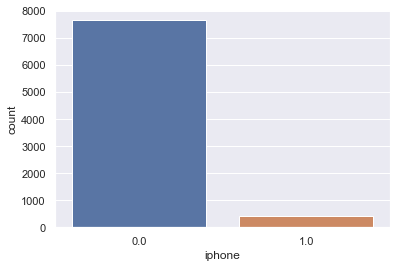

In [119]:
## Count of Android vs IOS
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="iphone", data=df)

In [122]:
## OLS results of heterogenous effect of phone systems
y = df['yes']
X = df['experiment']
X = sm.add_constant(X, prepend=False)
X['iphone'] = df['iphone']
X['experiment_iphone'] = X['experiment']*X['iphone']
ols_reg = sm.OLS(y, X).fit()
print(ols_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                    yes   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     9.125
Date:                Tue, 08 Jun 2021   Prob (F-statistic):           5.02e-06
Time:                        23:30:29   Log-Likelihood:                -457.98
No. Observations:                8077   AIC:                             924.0
Df Residuals:                    8073   BIC:                             952.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
experiment            0.0099      0.00

### Result: 
Users who were exposed to online interactive ad are more likely to click yes on BIO questionnaire, compared to users in the control group.
However, the results are driven by Android phones. iPhone Exposed user are not more likely to to click yes on BIO questionnaire.